In [2]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import json
import math

In [3]:
cf_2018 = pd.read_csv('flight_data/Combined_Flights_2018.csv')
cf_2018.head()

FlightDate            Airline Origin Dest  Cancelled  Diverted  CRSDepTime  \
0  2018-01-23  Endeavor Air Inc.    ABY  ATL      False     False        1202   
1  2018-01-24  Endeavor Air Inc.    ABY  ATL      False     False        1202   
2  2018-01-25  Endeavor Air Inc.    ABY  ATL      False     False        1202   
3  2018-01-26  Endeavor Air Inc.    ABY  ATL      False     False        1202   
4  2018-01-27  Endeavor Air Inc.    ABY  ATL      False     False        1400   

   DepTime  DepDelayMinutes  DepDelay  ...  WheelsOff  WheelsOn  TaxiIn  \
0   1157.0              0.0      -5.0  ...     1211.0    1249.0     7.0   
1   1157.0              0.0      -5.0  ...     1210.0    1246.0    12.0   
2   1153.0              0.0      -9.0  ...     1211.0    1251.0    11.0   
3   1150.0              0.0     -12.0  ...     1207.0    1242.0    11.0   
4   1355.0              0.0      -5.0  ...     1412.0    1448.0    11.0   

   CRSArrTime  ArrDelay  ArrDel15  ArrivalDelayGroups  ArrTimeBlk  \
0        1304      -8.0       0.0                -1.0   1300-1359   
1        1304      -6.0       0.0                -1.0   1300-1359   
2        1304      -2.0       0.0                -1.0   1300-1359   
3        1304     -11.0       0.0                -1.0   1300-1359   
4        1500      -1.0       0.0                -1.0   1500-1559   

   DistanceGroup  DivAirportLandings  
0              1                 0.0  
1              1                 0.0  
2              1                 0.0  
3              1                 0.0  
4              1                 0.0  

[5 rows x 61 columns]

In [4]:
# Filter the dataframe to include only the delays from JFK
import RegressionModel

filtered_df = cf_2018[(cf_2018['Origin'] == 'JFK')]

RegressionModel.destinations = list(cf_2018['DestCityName'].unique())

In [5]:
relevant_columns = ['FlightDate', 'Airline', 'Dest', 'DepDelayMinutes', 'ArrDelayMinutes']
jfk_flights_2018 = filtered_df[relevant_columns].copy()
jfk_flights_2018.dropna(inplace=True)

In [6]:
jfk_flights_2018

FlightDate               Airline Dest  DepDelayMinutes  \
5544     2018-01-22       JetBlue Airways  SJC              0.0   
5547     2018-01-22       JetBlue Airways  MSY             86.0   
5548     2018-01-22       JetBlue Airways  JAX             29.0   
5554     2018-01-22       JetBlue Airways  ROC              0.0   
5565     2018-01-22       JetBlue Airways  BUF              0.0   
...             ...                   ...  ...              ...   
5666920  2018-09-10  Delta Air Lines Inc.  SFO              0.0   
5666921  2018-09-10  Delta Air Lines Inc.  MSP              0.0   
5667057  2018-09-10  Delta Air Lines Inc.  LAX             13.0   
5667231  2018-09-10  Delta Air Lines Inc.  SEA             48.0   
5672362  2018-09-04     Endeavor Air Inc.  BNA              0.0   

         ArrDelayMinutes  
5544                 0.0  
5547                77.0  
5548                11.0  
5554                 0.0  
5565                 0.0  
...                  ...  
5666920              3.0  
5666921              0.0  
5667057              0.0  
5667231             44.0  
5672362              0.0  

[83754 rows x 5 columns]

In [9]:
# Convert 'FlightDate' into numerical components
jfk_flights_2018['FlightDate'] = pd.to_datetime(jfk_flights_2018['FlightDate'])
jfk_flights_2018['Year'] = jfk_flights_2018['FlightDate'].dt.year
jfk_flights_2018['Month'] = jfk_flights_2018['FlightDate'].dt.month
jfk_flights_2018['Day'] = jfk_flights_2018['FlightDate'].dt.day

# One-hot encoding for categorical variables
df_jfk_encoded = pd.get_dummies(jfk_flights_2018, columns=['Dest'])
df_jfk_encoded.head()


FlightDate          Airline  DepDelayMinutes  ArrDelayMinutes  Year  \
5544 2018-01-22  JetBlue Airways              0.0              0.0  2018   
5547 2018-01-22  JetBlue Airways             86.0             77.0  2018   
5548 2018-01-22  JetBlue Airways             29.0             11.0  2018   
5554 2018-01-22  JetBlue Airways              0.0              0.0  2018   
5565 2018-01-22  JetBlue Airways              0.0              0.0  2018   

      Month  Day  Dest_ABQ  Dest_ACK  Dest_ATL  ...  Dest_SFO  Dest_SJC  \
5544      1   22     False     False     False  ...     False      True   
5547      1   22     False     False     False  ...     False     False   
5548      1   22     False     False     False  ...     False     False   
5554      1   22     False     False     False  ...     False     False   
5565      1   22     False     False     False  ...     False     False   

      Dest_SJU  Dest_SLC  Dest_SMF  Dest_SNA  Dest_SRQ  Dest_STT  Dest_SYR  \
5544     False     False     False     False     False     False     False   
5547     False     False     False     False     False     False     False   
5548     False     False     False     False     False     False     False   
5554     False     False     False     False     False     False     False   
5565     False     False     False     False     False     False     False   

      Dest_TPA  
5544     False  
5547     False  
5548     False  
5554     False  
5565     False  

[5 rows x 78 columns]

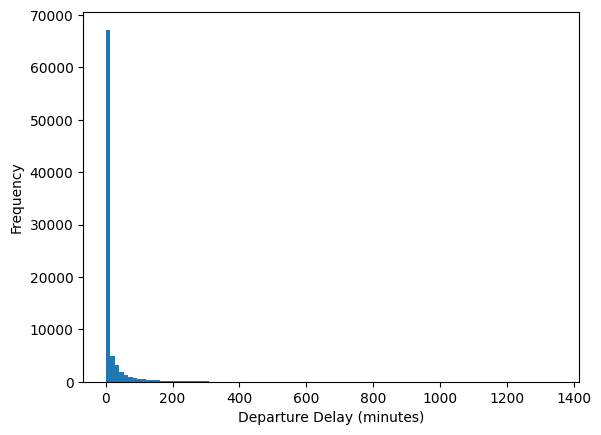

In [20]:
from sklearn.model_selection import train_test_split

# Choose your target variable, e.g., 'DepDelayMinutes'
X = df_jfk_encoded.drop('DepDelayMinutes', axis=1)
y = df_jfk_encoded['DepDelayMinutes']

# plot the distribution of the target variable
plt.hist(y, bins=100)
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.show()

In [ ]:


# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

In [ ]:


# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


In [ ]:
print(list(X_test))

In [ ]:

i = X_test.iloc[[3]].copy()
i['FlightDate'] = 1640995200000000000
i['Year'] = 2022
i['Month'] = 1
i['Day'] = 1
print(i)


In [ ]:
X_mike = X_test.iloc[[3]]

In [ ]:
model.predict(i)